In [1]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin
from tqdm import tqdm

from estimate_nc.estimate_nc import estimate_nc, en_per_particle

In [2]:
results = {}
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29

# Dy-DF

In [3]:
data = np.loadtxt("./results/critical-atom-numbers/dy-df/functionals_E_N.dat")
# the header is: a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  
# read all data
a_s = data[:,0]
n_c_best_possible_fit = data[:,1]
rho_min_x = data[:,2]
rho_max_x = data[:,3]
alpha = data[:,4]
alpha_opt = data[:,5]
beta = data[:,6]
gamma = data[:,7]

# Take only the data where rho_min_x is smaller than 0.7, and rho_max_x is larger than 2.0
indices = np.where((rho_min_x <= 0.7) & (rho_min_x >= 0.4) & (rho_max_x >= 1.5) & (rho_max_x <= 2.5))
a_s = a_s[indices]
n_c_best_possible_fit = n_c_best_possible_fit[indices]
rho_min_x = rho_min_x[indices]
rho_max_x = rho_max_x[indices]
alpha = alpha[indices]
alpha_opt = alpha_opt[indices]
beta = beta[indices]
gamma = gamma[indices]
set(rho_min_x), set(rho_max_x)

({0.5, 0.6}, {1.7, 1.9, 2.1, 2.3})

## Plot $\beta$ vs $a_s$

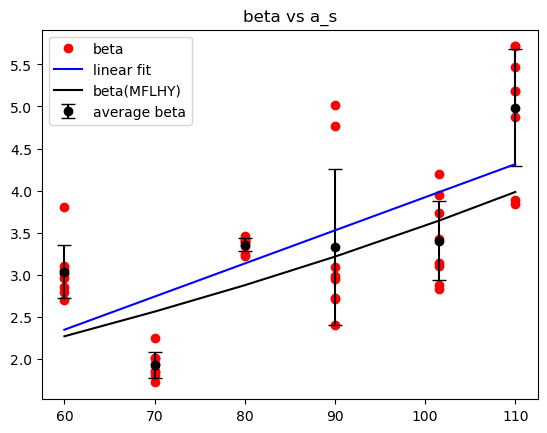

In [4]:
# Plot beta vs a_s
plt.plot(a_s, beta, 'o', label='beta', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(beta[a_s==a_s_unique[i]])
    std[i] = np.std(beta[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average beta', capsize=5, color='black')
# Make a linear fit of the average beta vs a_s
def func_beta(x, a, b):
    return a*x + b
popt_beta, pcov = curve_fit(func_beta, a_s_unique, average)
plt.plot(a_s_unique, func_beta(a_s_unique, *popt_beta), label='linear fit', color='blue')


beta_mflhy = 256*np.sqrt(np.pi)*(a_s_unique/r_0)**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt((a_s_unique/r_0))/45
plt.plot(a_s_unique,beta_mflhy, label='beta(MFLHY)', color='black')


plt.title("beta vs a_s")
plt.legend(loc='best')

## Plot $\gamma$ vs $a_s$

<f_gamma(a_s)> 1.7253964583333332


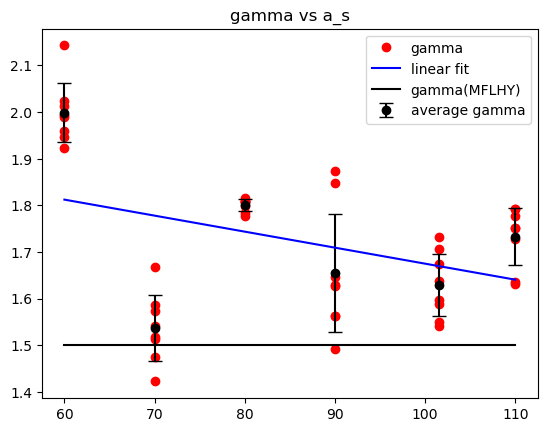

In [5]:
# Plot gamma vs a_s
plt.plot(a_s, gamma, 'o', label='gamma', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(gamma[a_s==a_s_unique[i]])
    std[i] = np.std(gamma[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average gamma', capsize=5, color='black')
# Make a linear fit of the average gamma vs a_s
def func_gamma(x, a, b):
    return a*x + b
popt_gamma, pcov = curve_fit(func_gamma, a_s_unique, average)
plt.plot(a_s_unique, func_gamma(a_s_unique, *popt_gamma), label='linear fit', color='blue')

print("<f_gamma(a_s)>", np.average(func_gamma(a_s_unique, *popt_gamma)))
plt.plot(a_s_unique,[1.5]*len(a_s_unique), label='gamma(MFLHY)', color='black')


plt.title("gamma vs a_s")
plt.legend(loc='best')

## Estimate $n_c$ for each $a_s$ value, using fits


In [12]:
a_s = np.arange(60, 110, 1)
a_s

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109])

In [13]:
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# for each a_s, find the best possible fit for n_c, using the fits func_beta and func_gamma
n_c_best_possible_fit = np.zeros(len(a_s))
for i in tqdm(range(len(a_s))):
    alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
    n_c_best_possible_fit[i] = estimate_nc(alpha,func_beta(a_s[i], *popt_beta), func_gamma(a_s[i], *popt_gamma), based_on="size", verbose=False)[0]


100%|██████████| 50/50 [03:26<00:00,  4.12s/it]


In [17]:
results["recipe-7-using-beta-gamma-fits"] = {"a_s": a_s, "n_c_best_possible_fit": n_c_best_possible_fit}

In [20]:
results

{'recipe-7-using-beta-gamma-fits': {'a_s': array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
          73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
          86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
          99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]),
  'n_c_best_possible_fit': array([  272.17729226,   292.01524643,   303.99381571,   339.52957361,
           353.45719749,   367.95613745,   383.04982908,   423.54867447,
           449.87531042,   477.83833861,   497.43943722,   550.03239335,
           572.59491776,   614.32915519,   665.76286908,   700.0734331 ,
           758.68594784,   813.98364347,   882.13310614,   946.42838951,
          1025.66657411,  1100.42345894,  1204.60063778,  1292.39933712,
          1386.59734537,  1517.86662943,  1661.56318735,  1800.67487506,
          1971.14491272,  2136.17582916,  2338.40776958,  2585.64143872,
          2830.42432515,  3129.67760349,  3460.57013952,  3865

In [23]:
import pandas as pd
df = pd.DataFrame(results["recipe-7-using-beta-gamma-fits"])
df.head()

,a_s,n_c_best_possible_fit
0,60,272.177292
1,61,292.015246
2,62,303.993816
3,63,339.529574
4,64,353.457197


In [24]:
df.to_csv("results/paper/critical_n.csv", index=False)